In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from PIL import Image
import matplotlib.pyplot as plt

print("Cell 1 executed successfully: Libraries imported")

Cell 1 executed successfully: Libraries imported


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"CUDA available: {torch.cuda.is_available()}")
print("Cell 2 executed successfully: Device set up")

Using device: cuda
CUDA available: True
Cell 2 executed successfully: Device set up


In [3]:
class DeepfakeDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ['Real', 'Fake']
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.images = self._load_images()

    def _load_images(self):
        images = []
        for cls in self.classes:
            class_dir = os.path.join(self.root_dir, cls)
            for img_name in os.listdir(class_dir):
                images.append((os.path.join(class_dir, img_name), self.class_to_idx[cls]))
        return images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

print("Cell 3 executed successfully: DeepfakeDataset class defined")

Cell 3 executed successfully: DeepfakeDataset class defined


In [4]:
class DeepfakeDetector(nn.Module):
    def __init__(self):
        super(DeepfakeDetector, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-2])
        
        self.fpn_layers = nn.ModuleList([
            nn.Conv2d(2048, 256, kernel_size=1),
            nn.Conv2d(1024, 256, kernel_size=1),
            nn.Conv2d(512, 256, kernel_size=1),
            nn.Conv2d(256, 256, kernel_size=1)
        ])
        
        self.top_down_layers = nn.ModuleList([
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.Conv2d(256, 256, kernel_size=3, padding=1)
        ])
        
        self.final_layer = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(256, 2)
        )

    def forward(self, x):
        c2 = self.resnet[:5](x)
        c3 = self.resnet[5](c2)
        c4 = self.resnet[6](c3)
        c5 = self.resnet[7](c4)
        
        p5 = self.fpn_layers[0](c5)
        p4 = self.fpn_layers[1](c4) + nn.functional.interpolate(p5, scale_factor=2, mode='nearest')
        p3 = self.fpn_layers[2](c3) + nn.functional.interpolate(p4, scale_factor=2, mode='nearest')
        p2 = self.fpn_layers[3](c2) + nn.functional.interpolate(p3, scale_factor=2, mode='nearest')
        
        d5 = self.top_down_layers[0](p5)
        d4 = self.top_down_layers[1](p4)
        d3 = self.top_down_layers[2](p3)
        d2 = self.top_down_layers[3](p2)
        
        d5 = nn.functional.interpolate(d5, size=d2.shape[2:], mode='nearest')
        d4 = nn.functional.interpolate(d4, size=d2.shape[2:], mode='nearest')
        d3 = nn.functional.interpolate(d3, size=d2.shape[2:], mode='nearest')
        
        combined = d5 + d4 + d3 + d2
        out = self.final_layer(combined)
        return out

print("Cell 4 executed successfully: DeepfakeDetector model defined")

Cell 4 executed successfully: DeepfakeDetector model defined


In [5]:
def preprocess_data():
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    train_dataset = DeepfakeDataset(root_dir='Dataset/Train', transform=transform)
    val_dataset = DeepfakeDataset(root_dir='Dataset/Validation', transform=transform)
    test_dataset = DeepfakeDataset(root_dir='Dataset/Test', transform=transform)

    print(f"Train dataset size: {len(train_dataset)}")
    print(f"Validation dataset size: {len(val_dataset)}")
    print(f"Test dataset size: {len(test_dataset)}")

    return train_dataset, val_dataset, test_dataset

print("Cell 5 executed successfully: Data preprocessing function defined")

Cell 5 executed successfully: Data preprocessing function defined


In [6]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
            if i % 10 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
        
        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/len(train_loader):.4f}, '
              f'Val Loss: {val_loss/len(val_loader):.4f}, Val Accuracy: {100 * correct / total:.2f}%')

print("Cell 6 executed successfully: Training function defined")

Cell 6 executed successfully: Training function defined


In [7]:
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    print(f'Test Accuracy: {accuracy:.4f}')
    print(f'Test Precision: {precision:.4f}')
    print(f'Test Recall: {recall:.4f}')
    print(f'Test F1-score: {f1:.4f}')

print("Cell 7 executed successfully: Evaluation function defined")

Cell 7 executed successfully: Evaluation function defined


In [8]:
train_dataset, val_dataset, test_dataset = preprocess_data()

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

model = DeepfakeDetector().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Cell 8 executed successfully: Data prepared and model created")

Train dataset size: 140002
Validation dataset size: 39428
Test dataset size: 10905


C:\Users\harsh\anaconda3\envs\deepfake_detector\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\harsh\anaconda3\envs\deepfake_detector\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Cell 8 executed successfully: Data prepared and model created


In [9]:
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)
print("Cell 9 executed successfully: Model training completed")

Epoch [1/10], Step [1/4376], Loss: 0.7243
Epoch [1/10], Step [11/4376], Loss: 11.9864
Epoch [1/10], Step [21/4376], Loss: 0.6506
Epoch [1/10], Step [31/4376], Loss: 1.8326
Epoch [1/10], Step [41/4376], Loss: 0.9510
Epoch [1/10], Step [51/4376], Loss: 0.8821
Epoch [1/10], Step [61/4376], Loss: 0.7768
Epoch [1/10], Step [71/4376], Loss: 0.6755
Epoch [1/10], Step [81/4376], Loss: 0.7051
Epoch [1/10], Step [91/4376], Loss: 0.7022
Epoch [1/10], Step [101/4376], Loss: 0.6644
Epoch [1/10], Step [111/4376], Loss: 0.6892
Epoch [1/10], Step [121/4376], Loss: 0.6645
Epoch [1/10], Step [131/4376], Loss: 0.6807
Epoch [1/10], Step [141/4376], Loss: 0.6845
Epoch [1/10], Step [151/4376], Loss: 0.7091
Epoch [1/10], Step [161/4376], Loss: 0.6406
Epoch [1/10], Step [171/4376], Loss: 0.6836
Epoch [1/10], Step [181/4376], Loss: 0.6610
Epoch [1/10], Step [191/4376], Loss: 0.6611
Epoch [1/10], Step [201/4376], Loss: 0.6751
Epoch [1/10], Step [211/4376], Loss: 0.6964
Epoch [1/10], Step [221/4376], Loss: 0.619

In [10]:
evaluate_model(model, test_loader)
print("Cell 10 executed successfully: Model evaluation completed")

Test Accuracy: 0.9074
Test Precision: 0.9087
Test Recall: 0.9074
Test F1-score: 0.9073
Cell 10 executed successfully: Model evaluation completed


In [11]:
torch.save(model.state_dict(), 'deepfake_detector.pth')
print("Cell 11 executed successfully: Model saved")

Cell 11 executed successfully: Model saved


In [12]:
def predict_image(model, image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    
    model.eval()
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output.data, 1)
    
    return "Fake" if predicted.item() == 1 else "Real"

print("Cell 12 executed successfully: Prediction function defined")

Cell 12 executed successfully: Prediction function defined


In [13]:
result = predict_image(model, 'aaaa.png')
print(f"The image is predicted to be: {result}")
print("Cell 13 executed successfully: Example prediction made")

The image is predicted to be: Real
Cell 13 executed successfully: Example prediction made


Cell 14 executed successfully: Additional libraries imported


C:\Users\harsh\AppData\Local\Temp\ipykernel_13836\2016701469.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('deepfake_detector.pth'))


Cell 15 executed successfully: Previously trained model loaded
Cell 16 executed successfully: Prediction function defined
Cell 17 executed successfully: Predictions obtained for test set


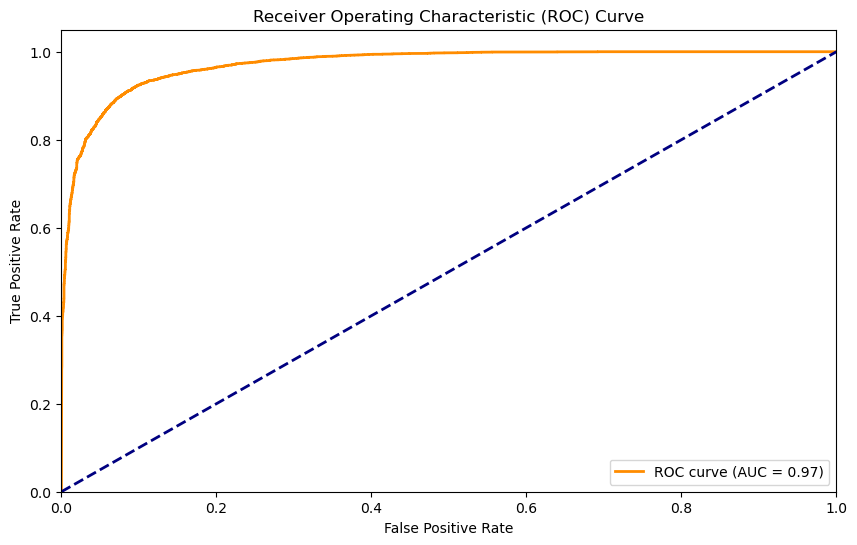

ROC AUC: 0.9714
Cell 18 executed successfully: ROC Curve plotted


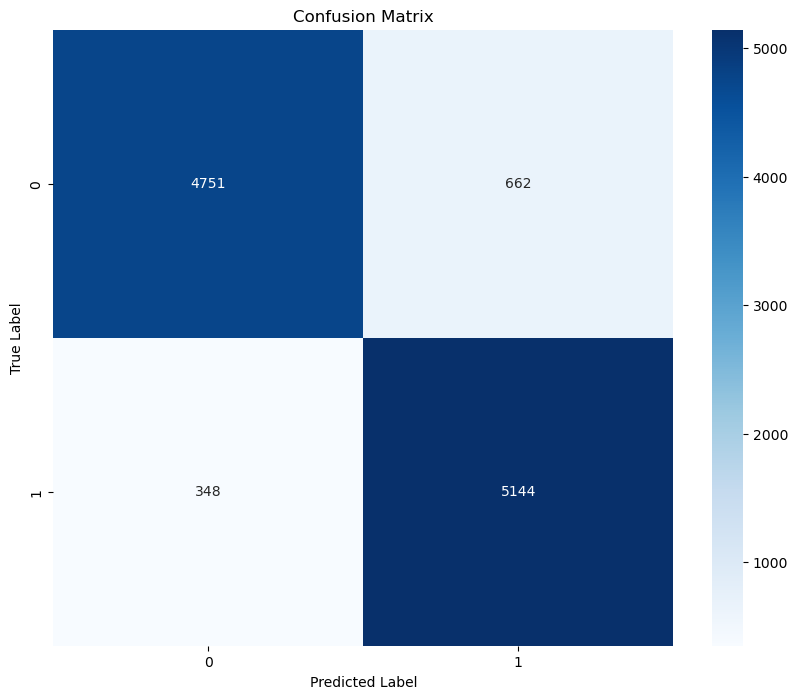

Cell 19 executed successfully: Confusion Matrix plotted
Accuracy: 0.9074
Precision: 0.8860
Recall (Sensitivity): 0.9366
F1-score: 0.9106
Specificity: 0.8777
ROC AUC: 0.9714
Cell 20 executed successfully: Additional metrics calculated


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

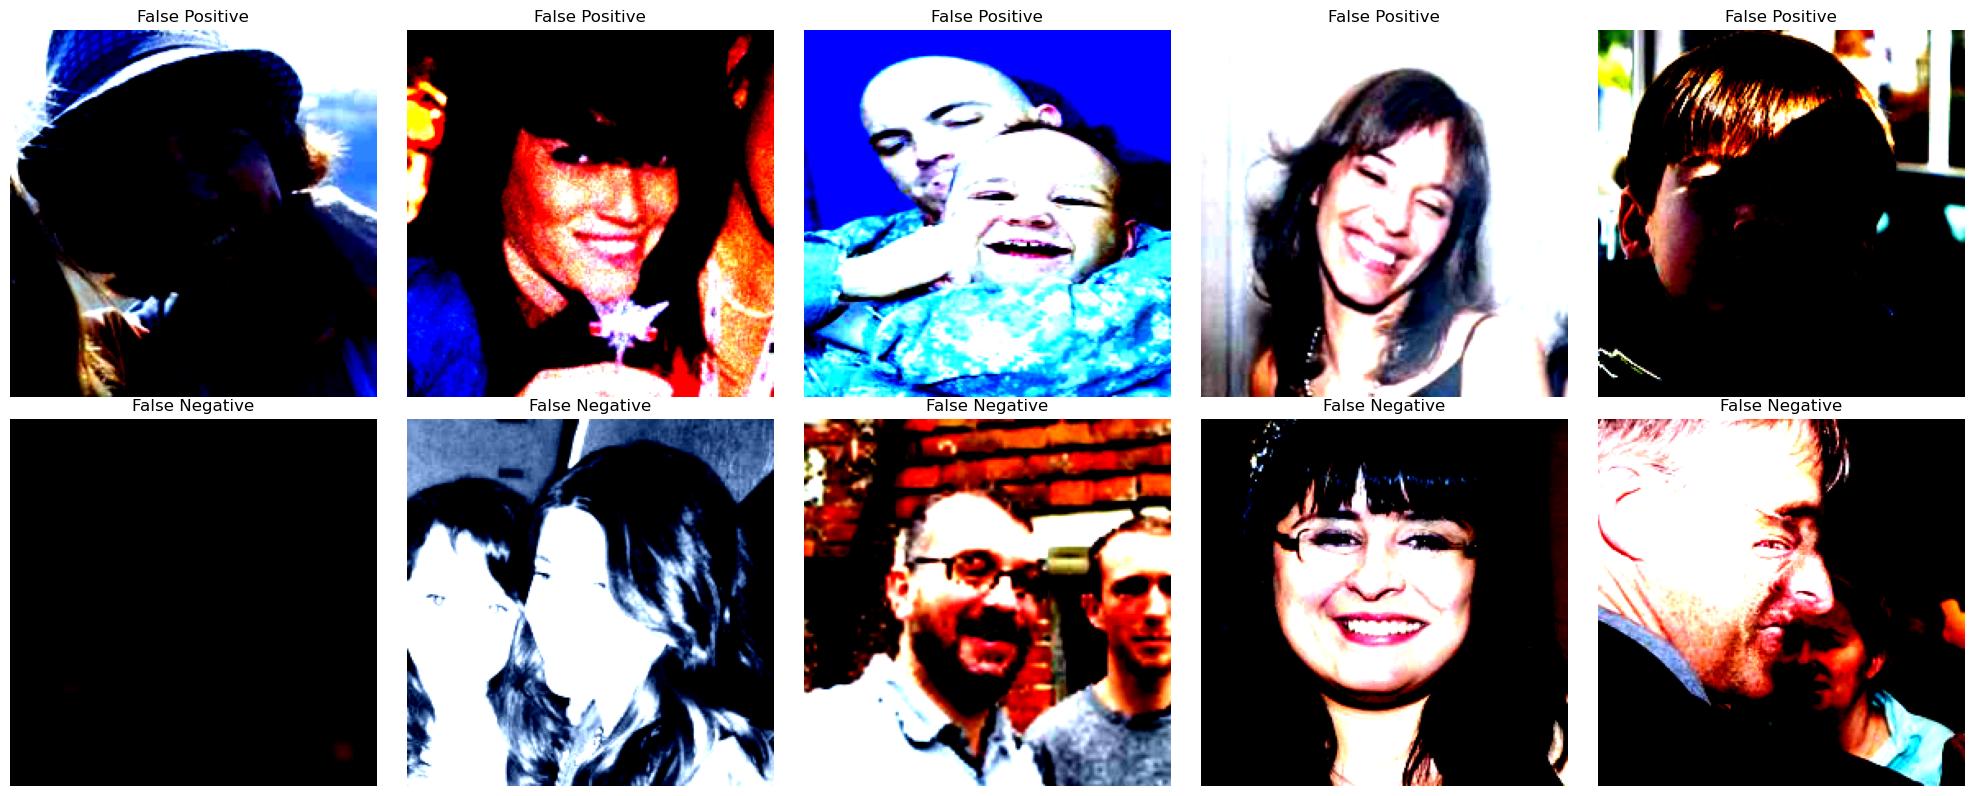

Cell 21 executed successfully: Error examples plotted


In [19]:
# Cell 14: Import additional libraries
import numpy as np
from sklearn.metrics import roc_curve, auc, confusion_matrix
import seaborn as sns

print("Cell 14 executed successfully: Additional libraries imported")

# Cell 15: Load the previously trained model
model = DeepfakeDetector().to(device)
model.load_state_dict(torch.load('deepfake_detector.pth'))
model.eval()

print("Cell 15 executed successfully: Previously trained model loaded")

# Cell 16: Function to get predictions and true labels
def get_predictions(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())  # Probability of being fake
    
    return np.array(all_preds), np.array(all_labels), np.array(all_probs)

print("Cell 16 executed successfully: Prediction function defined")

# Cell 17: Get predictions for test set
test_preds, test_labels, test_probs = get_predictions(model, test_loader)

print("Cell 17 executed successfully: Predictions obtained for test set")

# Cell 18: ROC Curve
def plot_roc_curve(y_true, y_scores):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    return roc_auc

roc_auc = plot_roc_curve(test_labels, test_probs)
print(f"ROC AUC: {roc_auc:.4f}")
print("Cell 18 executed successfully: ROC Curve plotted")

# Cell 19: Confusion Matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    return cm

cm = plot_confusion_matrix(test_labels, test_preds)
print("Cell 19 executed successfully: Confusion Matrix plotted")

# Cell 20: Additional Metrics
def calculate_metrics(confusion_matrix, roc_auc):
    tn, fp, fn, tp = confusion_matrix.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * (precision * recall) / (precision + recall)
    specificity = tn / (tn + fp)
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall (Sensitivity): {recall:.4f}")
    print(f"F1-score: {f1_score:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")

calculate_metrics(cm, roc_auc)
print("Cell 20 executed successfully: Additional metrics calculated")

# Cell 21: Error Analysis
def plot_error_examples(model, test_loader, num_examples=5):
    model.eval()
    errors = {'false_positives': [], 'false_negatives': []}
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            false_positives = (predicted == 1) & (labels == 0)
            false_negatives = (predicted == 0) & (labels == 1)
            
            errors['false_positives'].extend(images[false_positives].cpu())
            errors['false_negatives'].extend(images[false_negatives].cpu())
            
            if len(errors['false_positives']) >= num_examples and len(errors['false_negatives']) >= num_examples:
                break
    
    fig, axes = plt.subplots(2, num_examples, figsize=(20, 8))
    
    for i in range(num_examples):
        if i < len(errors['false_positives']):
            axes[0, i].imshow(errors['false_positives'][i].permute(1, 2, 0))
            axes[0, i].set_title('False Positive')
            axes[0, i].axis('off')
        
        if i < len(errors['false_negatives']):
            axes[1, i].imshow(errors['false_negatives'][i].permute(1, 2, 0))
            axes[1, i].set_title('False Negative')
            axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

plot_error_examples(model, test_loader)
print("Cell 21 executed successfully: Error examples plotted")